In [2]:
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data.cc"

In [3]:
# !curl -L https://github.com/petewarden/magic_wand_digit_data/archive/8170591863f9addca27b1a963263f7c7bed33f41.zip -o magic_wand_digit_data.zip
# !unzip magic_wand_digit_data.zip
# !rm -rf magic_wand_digit_data
# !mv magic_wand_digit_data-* magic_wand_digit_data
# !rm -rf magic_wand_digit_data.zip
# !rm -rf sample_data
# !mkdir -p checkpoints
#!pip install tensorflow
#!pip install pydot

In [4]:
import glob
import json
import os

SERVER_DATA_DIR = "Data/final_dataset_800/server"

strokes = []
for filename in glob.glob(os.path.join(SERVER_DATA_DIR, "*", "*.json")):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)
      
print(f"Loaded {len(strokes)} strokes from Server dataset.")

Loaded 400 strokes from Server dataset.


In [5]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

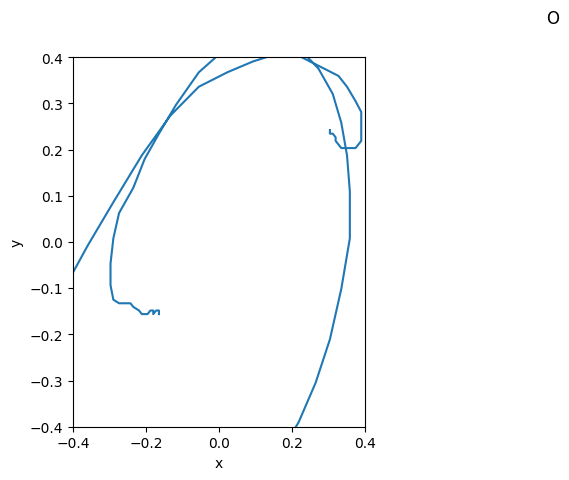

In [6]:
#for i in range(0, 900):
plot_stroke(strokes[200])

In [7]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

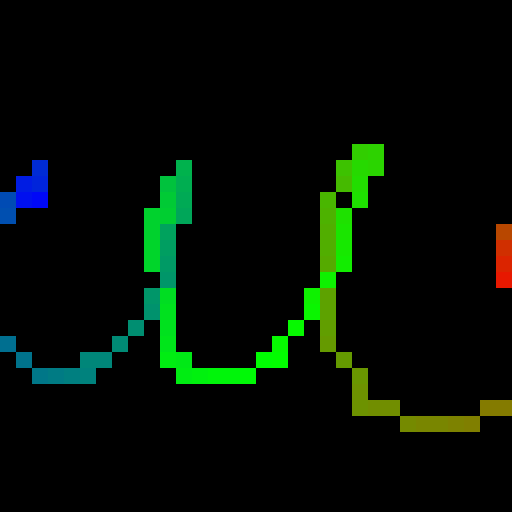

In [8]:

raster = rasterize_stroke(strokes[2]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [9]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [10]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [11]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 40 files belonging to 3 classes.
Found 3520 files belonging to 3 classes.


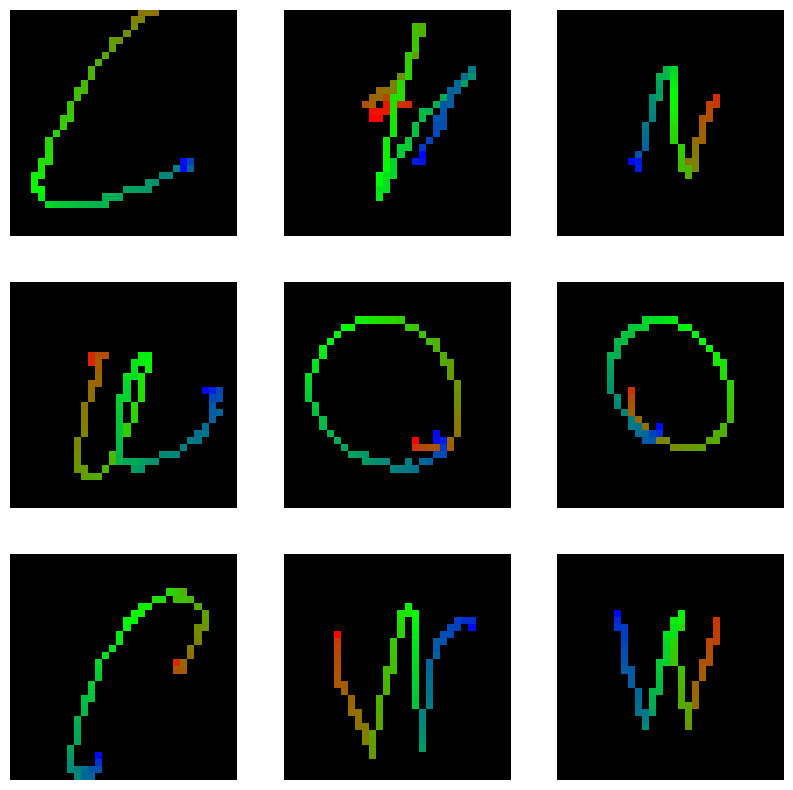

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [14]:
model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=3)
#keras.utils.plot_model(model, show_shapes=True)

In [15]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.h5"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4109 - loss: 0.6716

110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.4645 - loss: 0.6277 - val_accuracy: 0.4250 - val_loss: 0.6604 - learning_rate: 0.0010
Epoch 2/30
106/110 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5321 - loss: 0.5713

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5409 - loss: 0.5643 - val_accuracy: 0.4250 - val_loss: 0.7506 - learning_rate: 0.0010
Epoch 3/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5736 - loss: 0.5380

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5807 - loss: 0.5331 - val_accuracy: 0.4250 - val_loss: 0.7201 - learning_rate: 0.0010
Epoch 4/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6183 - loss: 0.4967

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6241 - loss: 0.4915 - val_accuracy: 0.4250 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 5/30
105/110 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6501 - loss: 0.4613

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6526 - loss: 0.4582 - val_accuracy: 0.6000 - val_loss: 0.4732 - learning_rate: 0.0010
Epoch 6/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6995 - loss: 0.4298

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7009 - loss: 0.4245 - val_accuracy: 0.6750 - val_loss: 0.4078 - learning_rate: 0.0010
Epoch 7/30
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7193 - loss: 0.4108

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7287 - loss: 0.4030 - val_accuracy: 0.6000 - val_loss: 0.3982 - learning_rate: 0.0010
Epoch 8/30
106/110 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7491 - loss: 0.3854

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7452 - loss: 0.3858 - val_accuracy: 0.7000 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 9/30
104/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7493 - loss: 0.3823

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7526 - loss: 0.3739 - val_accuracy: 0.7500 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 10/30
107/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7616 - loss: 0.3643

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7670 - loss: 0.3529 - val_accuracy: 0.7750 - val_loss: 0.3047 - learning_rate: 0.0010
Epoch 11/30
103/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7699 - loss: 0.3423

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7722 - loss: 0.3444 - val_accuracy: 0.8250 - val_loss: 0.3036 - learning_rate: 0.0010
Epoch 12/30
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7855 - loss: 0.3413

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7957 - loss: 0.3312 - val_accuracy: 0.8750 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 13/30
106/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7810 - loss: 0.3311

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7855 - loss: 0.3262 - val_accuracy: 0.8750 - val_loss: 0.2808 - learning_rate: 0.0010
Epoch 14/30
104/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7893 - loss: 0.3177

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8000 - loss: 0.3166 - val_accuracy: 0.8750 - val_loss: 0.2841 - learning_rate: 0.0010
Epoch 15/30
104/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8190 - loss: 0.3016

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8162 - loss: 0.3082 - val_accuracy: 0.8250 - val_loss: 0.3347 - learning_rate: 0.0010
Epoch 16/30
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8101 - loss: 0.3049

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8176 - loss: 0.3013 - val_accuracy: 0.7500 - val_loss: 0.2953 - learning_rate: 0.0010
Epoch 17/30
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8222 - loss: 0.2915

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8264 - loss: 0.2892 - val_accuracy: 0.7750 - val_loss: 0.2803 - learning_rate: 5.0000e-04
Epoch 18/30
107/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8193 - loss: 0.2919

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8239 - loss: 0.2906 - val_accuracy: 0.8000 - val_loss: 0.2491 - learning_rate: 5.0000e-04
Epoch 19/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8360 - loss: 0.2825

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8358 - loss: 0.2802 - val_accuracy: 0.8250 - val_loss: 0.2436 - learning_rate: 5.0000e-04
Epoch 20/30
108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8334 - loss: 0.2798

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8287 - loss: 0.2800 - val_accuracy: 0.8250 - val_loss: 0.3133 - learning_rate: 5.0000e-04
Epoch 21/30
107/110 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8405 - loss: 0.2660

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8403 - loss: 0.2708 - val_accuracy: 0.7750 - val_loss: 0.2718 - learning_rate: 5.0000e-04
Epoch 22/30
104/110 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8333 - loss: 0.2682

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8338 - loss: 0.2694 - val_accuracy: 0.8500 - val_loss: 0.2390 - learning_rate: 5.0000e-04
Epoch 23/30
105/110 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8256 - loss: 0.2810

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8284 - loss: 0.2778 - val_accuracy: 0.8500 - val_loss: 0.2349 - learning_rate: 5.0000e-04
Epoch 24/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8333 - loss: 0.2756

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8372 - loss: 0.2725 - val_accuracy: 0.8750 - val_loss: 0.2288 - learning_rate: 5.0000e-04
Epoch 25/30
104/110 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8428 - loss: 0.2726

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8313 - loss: 0.2787 - val_accuracy: 0.8750 - val_loss: 0.2348 - learning_rate: 5.0000e-04
Epoch 26/30
105/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8523 - loss: 0.2528

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8463 - loss: 0.2589 - val_accuracy: 0.9000 - val_loss: 0.2597 - learning_rate: 5.0000e-04
Epoch 27/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8447 - loss: 0.2622

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8418 - loss: 0.2639 - val_accuracy: 0.8750 - val_loss: 0.2315 - learning_rate: 5.0000e-04
Epoch 28/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8378 - loss: 0.2695

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8423 - loss: 0.2625 - val_accuracy: 0.9000 - val_loss: 0.2313 - learning_rate: 2.5000e-04
Epoch 29/30
103/110 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8444 - loss: 0.2571

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8474 - loss: 0.2586 - val_accuracy: 0.8750 - val_loss: 0.2261 - learning_rate: 2.5000e-04
Epoch 30/30
107/110 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8532 - loss: 0.2569

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8457 - loss: 0.2573 - val_accuracy: 0.8750 - val_loss: 0.2238 - learning_rate: 2.5000e-04


In [16]:
def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)
  
index, score = predict_image(model, "test/o/3.png")

print(index, score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
0 0.7087657


In [17]:
import os
import glob
import json
import numpy as np
import tensorflow as tf
from PIL import Image

# =============================================================================
# 1. Setup Backbone Model
# =============================================================================
# Extract 64-dim features from the GlobalAveragePooling2D layer (index -3)
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
print(f"Backbone initialized. Output shape: {feature_extractor.output_shape}")

# =============================================================================
# 2. Data Processing Utils
# =============================================================================
# Label mapping: n=0, o=1, w=2
LABEL_MAP = {'n': 0, 'o': 1, 'w': 2, 'N': 0, 'O': 1, 'W': 2}
IMG_W, IMG_H = 32, 32

def process_dataset(root_dir):
    """
    Reads all JSONs in root_dir (subfolders n, o, w), rasterizes them,
    and extracts features using the backbone.
    Returns: (features_array, labels_array)
    """
    features = []
    labels = []
    
    # Iterate through subfolders (n, o, w)
    for label_name in os.listdir(root_dir):
        if label_name.lower() not in LABEL_MAP: continue
        
        label_val = LABEL_MAP[label_name.lower()]
        folder_path = os.path.join(root_dir, label_name)
        json_files = glob.glob(os.path.join(folder_path, "*.json"))
        
        print(f"Processing {label_name} in {root_dir}: found {len(json_files)} files.")
        
        for jf in json_files:
            try:
                with open(jf, 'r') as f:
                    data = json.load(f)
                
                # Iterate strokes in single JSON
                for stroke in data["strokes"]:
                    # Rasterize (using the function defined in previous cells)
                    raster = rasterize_stroke(stroke["strokePoints"], 0.6, 0.6, IMG_W, IMG_H)
                    
                    # Preprocess for model (1, 32, 32, 3)
                    img = Image.fromarray(raster).convert("RGB")
                    x = tf.keras.preprocessing.image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    
                    # Extract feature
                    feat = feature_extractor.predict(x, verbose=0)[0]
                    features.append(feat)
                    labels.append(label_val)
            except Exception as e:
                print(f"Error processing {jf}: {e}")
                
    return np.array(features), np.array(labels)

def write_data_h(filename, train_x, train_y, val_x, val_y, test_x, test_y):
    """Writes data to a C++ header file matching the template."""
    with open(filename, 'w') as f:
        f.write(f"// Data generated for {filename}\n")
        f.write("#include <cstdint>\n\n")
        
        # Write constants
        f.write(f"const int first_layer_input_cnt = 64;\n")
        f.write(f"const int train_data_cnt = {len(train_y)};\n")
        f.write(f"const int validation_data_cnt = {len(val_y)};\n")
        f.write(f"const int test_data_cnt = {len(test_y)};\n")
        f.write(f"const int classes_cnt = 3;\n\n")
        
        # Helper to write arrays
        def write_arr(name, dtype, data, dim=1):
            f.write(f"const {dtype} {name}")
            if dim == 2:
                f.write(f"[{len(data)}][64] = {{\n")
                for row in data:
                    f.write("  {" + ", ".join([f"{v:.6f}" for v in row]) + "},\n")
            else:
                f.write(f"[{len(data)}] = {{\n  ")
                f.write(", ".join(map(str, data)))
            f.write("\n};\n\n")

        # Write Labels
        write_arr("train_labels", "int", train_y)
        write_arr("validation_labels", "int", val_y)
        write_arr("test_labels", "int", test_y)
        
        # Write Features
        write_arr("train_data", "float", train_x, dim=2)
        write_arr("validation_data", "float", val_x, dim=2)
        write_arr("test_data", "float", test_x, dim=2) # Using float for features
        
    print(f"Successfully generated: {filename}")

# =============================================================================
# 3. Main Execution
# =============================================================================
BASE_DATA_DIR = "Data/final_dataset_800"

# 3.1 Load Global Test Set (Used for both clients)
print("--- Loading Test Data ---")
test_x, test_y = process_dataset(os.path.join(BASE_DATA_DIR, "test"))

# 3.2 Process Client A (N, O) -> client_A_data.h
print("\n--- Processing Client A ---")
x_a, y_a = process_dataset(os.path.join(BASE_DATA_DIR, "client_A"))

# Split A: 80% Train, 20% Test
idx_a = np.arange(len(y_a))
np.random.shuffle(idx_a)
split_a = int(len(y_a) * 0.8)
train_x_a, val_x_a = x_a[idx_a[:split_a]], x_a[idx_a[split_a:]]
train_y_a, val_y_a = y_a[idx_a[:split_a]], y_a[idx_a[split_a:]]

write_data_h("client_A_data.h", train_x_a, train_y_a, val_x_a, val_y_a, test_x, test_y)

# 3.3 Process Client B (N, W) -> client_B_data.h
print("\n--- Processing Client B ---")
x_b, y_b = process_dataset(os.path.join(BASE_DATA_DIR, "client_B"))

# Split B: 80% Train, 20% Test
idx_b = np.arange(len(y_b))
np.random.shuffle(idx_b)
split_b = int(len(y_b) * 0.8)
train_x_b, val_x_b = x_b[idx_b[:split_b]], x_b[idx_b[split_b:]]
train_y_b, val_y_b = y_b[idx_b[:split_b]], y_b[idx_b[split_b:]]

write_data_h("client_B_data.h", train_x_b, train_y_b, val_x_b, val_y_b, test_x, test_y)

Backbone initialized. Output shape: (None, 64)
--- Loading Test Data ---
Processing N in Data/final_dataset_800\test: found 40 files.
Processing O in Data/final_dataset_800\test: found 20 files.
Processing W in Data/final_dataset_800\test: found 20 files.

--- Processing Client A ---
Processing N in Data/final_dataset_800\client_A: found 80 files.
Processing O in Data/final_dataset_800\client_A: found 80 files.
Successfully generated: client_A_data.h

--- Processing Client B ---
Processing N in Data/final_dataset_800\client_B: found 80 files.
Processing W in Data/final_dataset_800\client_B: found 80 files.
Successfully generated: client_B_data.h


In [18]:
from IPython.display import Image, display

SCORE_THRESHOLD = 0.7

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test/*"):
  label = (label_dir.replace("test/", ""))
  if(label == 'test\\n'):
    label = 0
  if(label == 'test\\w'):
    label = 2
  if(label == 'test\\o'):
    label = 1
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
      continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      # print("%s expected, %d found with score %f" % (label, index, score))
      # display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [19]:
# from tinymlgen import port

# c_code = port(model, variable_name='spell_model', pretty_print=True,optimize=False)
# filename = 'net.h'
# with open(filename,'w') as f: 
#    f.write(c_code)

In [20]:
model.save(SAVED_MODEL_FILENAME+".h5")

In [21]:
#!curl -L https://storage.googleapis.com/download.tensorflow.org/models/tflite/micro/magic_wand_saved_model_2021_01_02.tgz -o saved_model.tgz
#!tar -xzf saved_model.tgz

In [22]:
backbone = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
converter = tf.lite.TFLiteConverter.from_keras_model(backbone)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis   for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpibijp886\assets


INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpibijp886\assets


Saved artifact at 'C:\Users\hugo-\AppData\Local\Temp\tmpibijp886'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 64), dtype=tf.float32, name=None)
Captures:
  2862503802064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503802640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503803984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503804176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503801872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503796880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503803024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503804752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503803216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503804368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  286250

INFO:tensorflow:Assets written to: C:\Users\hugo-\AppData\Local\Temp\tmpb0tz845y\assets


Saved artifact at 'C:\Users\hugo-\AppData\Local\Temp\tmpb0tz845y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 64), dtype=tf.float32, name=None)
Captures:
  2862503802064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503802640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503803984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503804176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503801872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503796880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503803024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503804752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503803216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2862503804368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  286250

c:\Users\hugo-\anaconda3\envs\test2_tut0\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


30024

In [23]:
def predict_backbone_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  return pred
  #predicted_label_index = np.argmax(pred)
  #predicted_score = pred[predicted_label_index]
  #return (predicted_label_index, predicted_score)
# Test on a single image
test_files = glob.glob("test/*/*.png")

if len(test_files) > 0:
    test_image = test_files[0]
    print(f"Testing TFLite Backbone on: {test_image}")
    
    # Run prediction
    features = predict_backbone_tflite(model_tflite, test_image)
    
    print("-" * 30)
    print(f"Output Shape: {features.shape}")
    print("Feature Vector (first 10 values):")
    print(features[:10]) # Print first 10 values to verify
    print("-" * 30)
    
    if features.shape == (64,):
        print("✅ Success! The TFLite model outputs a 64-dim vector.")
    else:
        print("❌ Warning: Unexpected output shape.")
else:
    print("❌ No test images found.")

Testing TFLite Backbone on: test\n\0.png
------------------------------
Output Shape: (64,)
Feature Vector (first 10 values):
[0.36767024 0.14232397 0.5337149  0.         0.6285975  0.32022893
 0.21348596 0.3439496  0.39139092 0.        ]
------------------------------
✅ Success! The TFLite model outputs a 64-dim vector.


c:\Users\hugo-\anaconda3\envs\test2_tut0\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [24]:
#predict_tflite(model_no_quant_tflite, "test/o/2.png")
predict_backbone_tflite(model_no_quant_tflite, "test/o/2.png")

array([8.04222655e-03, 2.07315058e-01, 0.00000000e+00, 4.07373339e-01,
       2.13570073e-02, 1.13472040e-03, 1.01032443e-01, 4.91632335e-03,
       0.00000000e+00, 5.62685907e-01, 2.69764841e-01, 3.10607404e-01,
       2.27451667e-01, 1.80481374e-01, 4.72173512e-01, 2.70816058e-01,
       2.46331349e-01, 4.30485606e-01, 4.56068397e-01, 0.00000000e+00,
       6.98417937e-03, 1.09476931e-01, 5.28327584e-01, 2.21225172e-01,
       3.36370766e-01, 1.63715391e-03, 2.43979841e-01, 5.05711377e-01,
       4.33009684e-01, 4.56355274e-01, 0.00000000e+00, 4.72803384e-01,
       5.19158617e-02, 9.45606548e-03, 4.68716562e-01, 2.49107793e-01,
       0.00000000e+00, 4.79563922e-01, 3.45538394e-03, 0.00000000e+00,
       1.64863691e-02, 2.92334050e-01, 5.93118727e-01, 1.50878012e-01,
       3.94553458e-03, 4.39858921e-02, 4.22467850e-02, 3.08856726e-01,
       4.80641603e-01, 1.11965346e-04, 4.61262912e-01, 0.00000000e+00,
       2.53593326e-01, 4.91987616e-01, 0.00000000e+00, 5.39045572e-01,
      

In [25]:
predict_backbone_tflite(model_tflite, "test/o/2.png")

array([0.        , 0.23720661, 0.        , 0.40325123, 0.01186033,
       0.        , 0.09488264, 0.        , 0.        , 0.5455752 ,
       0.3083686 , 0.36767024, 0.24906695, 0.20162562, 0.4625529 ,
       0.24906695, 0.23720661, 0.45069256, 0.43883222, 0.        ,
       0.        , 0.13046363, 0.5218545 , 0.24906695, 0.37953058,
       0.        , 0.28464794, 0.4981339 , 0.4269719 , 0.43883222,
       0.        , 0.47441322, 0.04744132, 0.        , 0.4625529 ,
       0.2727876 , 0.        , 0.47441322, 0.        , 0.        ,
       0.01186033, 0.32022893, 0.5811562 , 0.17790496, 0.        ,
       0.03558099, 0.03558099, 0.29650825, 0.4625529 , 0.        ,
       0.43883222, 0.        , 0.28464794, 0.48627356, 0.        ,
       0.5218545 , 0.01186033, 0.03558099, 0.        , 0.        ,
       0.01186033, 0.32022893, 0.        , 0.        ], dtype=float32)

In [29]:
import os
import pandas as pd

def get_size(path):
    if os.path.isfile(path):
        return os.path.getsize(path)
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size
#def get_dir_size(dir):
#  size = 0
#  for f in os.scandir(dir):
#    if f.is_file():
#      size += f.stat().st_size
#    elif f.is_dir():
#      size += get_dir_size(f.path)
#  return size

# Calculate size
size_tf = get_size(SAVED_MODEL_FILENAME+".h5")
size_no_quant_tflite = get_size(FLOAT_TFL_MODEL_FILENAME)
size_tflite = get_size(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,362600 bytes,
TensorFlow Lite,97804 bytes,(reduced by 264796 bytes)
TensorFlow Lite Quantized,30024 bytes,(reduced by 67780 bytes)


In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

'apt-get' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'xxd' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'sed' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [ ]:
# Print the C source file
!tail {TFL_CC_MODEL_FILENAME}

  0x04, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xd0, 0xff, 0xff, 0xff,
  0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x19,
  0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28, 0x0c, 0x00, 0x10, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_data_len = 30912;


In [ ]:
# import csv

# labells = []

# csvfile_r = open("Data/O_first_last.csv")
# csvreader_r = csv.reader(csvfile_r)
# for row in csvreader_r:
#     labells.append(row[1])

# labells.remove("last")
# csvfile_r.close()
        
# i = 0

# rows = []



# csvfile_w = open("Data/O_body_padded.csv", "r")
# csvreader_w = csv.reader(csvfile_w)
# for row in csvreader_w:
#     rows_m = []
#     for item in row:
#         rows_m.append(item)
#     rows_m.append(labells[i])
#     i += 1
#     rows.append(rows_m)

# csvfile_w.close()

# with open('Data/O_body_padded_labels.csv', 'w', newline='') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
#     for row in rows:
#         spamwriter.writerow(row)
